# Vision transformer

Vision transformer for CIFAR10.

- Imports, including `torch` and `pytorch_lightning`.
- Calculate means and stdevs for data normalization.
- Train, val, and test datasets and dataloaders.
- Function to patchify input images and return the flattened patches. (Using `einops rearrange` really helps here.)
- Standard `MultiHeadAttention` class.
- `EncoderBlock` class using 'pre'-layer norm. The FFN uses GELU activation.
-  `VisionTransformer` class. An input tensor size `(128, 3, 32, 32)` is patchified (with a patch size of 4) and flattened to `(128, 64, 48)`. This is put through a linear embedding layer. If the out-size of the embedding layer is `d_model = 256`, then the output is size `(128, 64, 256)`. After adding a classification token to the input, the size is `(128, 65, 256)`. Learnable positional encodings (size `(1, 65, 256)`) are added next. The whole thing goes through the encoder blocks, and the feature vector of the classification token goes through a linear classificiation head for classification.
- `ViT` Lightning module.
- Function to train and evaluate model.
- Train model (very briefly) and evaluate model.

### Imports

In [26]:
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

from einops import rearrange

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

pl.seed_everything(42)

from IPython.display import Image

DATASET_PATH = 'data'
CHECKPOINT_PATH = 'checkpoints'

Seed set to 42


### Means and stdevs for normalization

In [27]:
train_data = CIFAR10(root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_data.data / 255.0).mean(axis=(0,1,2))
DATA_STDS = (train_data.data / 255.0).std(axis=(0,1,2))
print("Means", DATA_MEANS)
print("Stdevs", DATA_STDS)

Files already downloaded and verified
Means [0.49139968 0.48215841 0.44653091]
Stdevs [0.24703223 0.24348513 0.26158784]


### Datasets and dataloaders

In [28]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8,1.0), ratio=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STDS) 
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STDS) 
])

train_dataset = CIFAR10(DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(DATASET_PATH, train=True, transform=test_transform, download=True)

train_ds, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_ds = torch.utils.data.random_split(val_dataset, [45000, 5000])

test_ds = CIFAR10(DATASET_PATH, train=False, transform=test_transform, download=True)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Function to patchify images and flatten the patches

In [29]:
def ims_to_flattened_patches(imgs, patch_size=4):
    flattened_patches = rearrange(imgs, 
                'b c (h p1) (w p2) -> b (h w) (c p1 p2)', 
                p1=patch_size, p2=patch_size)
    return flattened_patches

### Multi-head attention

In [30]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v):
        super().__init__()
        self.n_head = n_head
        self.d_k = d_k

        self.wq = nn.Linear(d_model, n_head * d_k)
        self.wk = nn.Linear(d_model, n_head * d_k)
        self.wv = nn.Linear(d_model, n_head * d_v)

        self.linear = nn.Linear(n_head * d_v, d_model)  

    def forward(self, q, k, v, mask=None):
        q = rearrange(self.wq(q), 'b t (h k) -> b h t k', h=self.n_head)    
        k = rearrange(self.wk(k), 'b s (h k) -> b h s k', h=self.n_head)
        v = rearrange(self.wv(v), 'b s (h v) -> b h s v', h=self.n_head)
        attn = torch.einsum('bhtk, bhsk -> bhts', q, k) / np.sqrt(self.d_k)
        if mask is not None:
            attn = attn.masked_fill(mask==0, -np.inf)
        attn = F.softmax(attn, dim=3)
        out = torch.einsum('bhts, bhsv -> bhtv', attn, v)
        out = rearrange(out, 'b h t v -> b t (h v)')
        out = self.linear(out)
        return out, attn

### Encoder block

Use Pre-LN version with GELU.

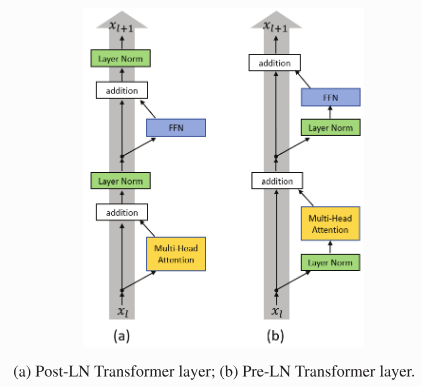

In [31]:
Image('images/pre-ln-transformer.png')

In [32]:
class EncoderBlock(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, d_ff, dropout_prob=0.0):
        super().__init__()
        self.attn = MultiHeadAttention(n_head, d_model, d_k, d_v)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout_prob)
        )

    def forward(self, x, mask=None):
        attn_in = self.ln1(x)
        x = x + self.attn(attn_in, attn_in, attn_in, mask)[0]
        x = x + self.mlp(self.ln2(x))
        return x

### Vision transformer

In [33]:
class VisionTransformer(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, d_ff, 
            n_enc_blocks, n_classes, n_patches, patch_size,  
            dropout_prob=0.0):
        super().__init__()
        self.patch_size = patch_size
        self.patch_embed = nn.Linear(3 * patch_size ** 2, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.randn(1, n_patches + 1, d_model))
        self.dropout = nn.Dropout(dropout_prob)
        self.encoder = nn.Sequential(*[EncoderBlock(
            n_head, d_model, d_k, d_v, d_ff, dropout_prob) 
            for _ in range(n_enc_blocks)])
        self.classification_head = nn.Linear(d_model, n_classes)
    
    def forward(self, x):
        x = ims_to_flattened_patches(x, patch_size=self.patch_size)
        b, t, _ = x.shape
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.repeat(b, 1, 1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.dropout(x)
        x = self.encoder(x)
        cls = x[:, 0, :]
        out = self.classification_head(cls)
        return out 

### Lightning module

In [34]:
class ViT(pl.LightningModule):

    def __init__(self, model_kwargs, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=self.hparams.lr
            )
        return optimizer
    
    def _calculate_loss(self, batch, mode='train'):
        imgs, labels = batch
        preds = self(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=1) == labels).float().mean()

        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, 'train')
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, 'val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, 'test')

### Function to train and evaluate vision transformer

In [35]:
def train_vit(**kwargs):
    trainer = Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, 'ViT'),
        accelerator='cpu',
        max_epochs=4,
        callbacks=[ModelCheckpoint(save_weights_only=True, monitor='val_acc', mode='max')],
        enable_progress_bar=True,
        limit_train_batches=0.2,
        limit_val_batches=0.2,
        limit_test_batches=0.3
    )
    trainer.logger._default_hp_metric = None
    pl.seed_everything(42)

    model = ViT(**kwargs)    
    trainer.fit(model, train_loader, val_loader)
    model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

### Train and evaluate model

In [36]:
# model, result = train_vit(model_kwargs = {
#     'n_head': 8,
#     'd_model': 256,
#     'd_k': 32,
#     'd_v': 32,
#     'd_ff': 512,
#     'n_enc_blocks': 6,
#     'n_classes': 10,
#     'n_patches': 64,
#     'patch_size': 4,
#     'dropout_prob': 0.1
# }, 
# lr=1e-4)

model, result = train_vit(model_kwargs = {
    'n_head': 4,
    'd_model': 128,
    'd_k': 16,
    'd_v': 16,
    'd_ff': 256,
    'n_enc_blocks': 4,
    'n_classes': 10,
    'n_patches': 64,
    'patch_size': 4,
    'dropout_prob': 0.1
}, 
lr=1e-4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | VisionTransformer | 414 K  | train
----------------------------------------------------
414 K     Trainable params
0         Non-trainable params
414 K     Total params
1.656     Total estimated model params size (MB)
61        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 70/70 [00:33<00:00,  2.12it/s, v_num=2]          

`Trainer.fit` stopped: `max_epochs=4` reached.


Testing DataLoader 0: 100%|██████████| 23/23 [00:03<00:00,  6.17it/s]


In [37]:
print(f"Val accuracy:  {(100.0 * result['val']):4.2f}%")
print(f"Test accuracy: {(100.0 * result['test']):4.2f}%")

Val accuracy:  32.42%
Test accuracy: 32.88%


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 414,090 trainable parameters
